# GPU chromvar

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from tqdm.auto import trange, tqdm
import os
from scprinter.chromvar import *
import scprinter as scp
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import time
import warnings
warnings.filterwarnings("ignore")
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    pool_allocator=True, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
import cupy as cp
cp.cuda.set_allocator(rmm_cupy_allocator)

Just as a comparison, let's load the R version of chromvar results. 

In [2]:
results_r = pd.read_csv("motifZ_mouse_YO_cultured.txt.zip", sep='\t')
ori_barcodes = [xx.split("_")[-1] for xx in results_r.index]
results_r.index = ori_barcodes
results_r

,ENSMUSG00000079808_LINE1933_AC1689771_I,ENSMUSG00000026491_LINE24_Ahctf1_D,ENSMUSG00000019256_LINE64_Ahr_D,ENSMUSG00000000731_LINE1926_Aire_D,ENSMUSG00000036602_LINE1477_Alx1_D_N3,ENSMUSG00000014603_LINE1334_Alx3_D,ENSMUSG00000040310_LINE1511_Alx4_D_N1,ENSMUSG00000046532_LINE1867_Ar_D_N2,ENSMUSG00000033237_LINE22_Arid2_I,ENSMUSG00000019564_LINE14_Arid3a_D_N3,...,ENSMUSG00000018347_LINE379_Zkscan6_I,ENSMUSG00000023902_LINE425_Zscan10_D_N2,ENSMUSG00000061894_LINE336_Zscan20_D,ENSMUSG00000022228_LINE405_Zscan26_D,ENSMUSG00000050619_LINE335_Zscan29_I,ENSMUSG00000095339_LINE1021_Zscan4b_I,ENSMUSG00000054272_LINE717_Zscan4c_D,ENSMUSG00000090714_LINE991_Zscan4d_I,ENSMUSG00000070828_LINE872_Zscan4f_I,ENSMUSG00000039068_LINE1762_Zzz3_I
"ACAGTGGT,ACTTGATG,TCTGCTGT,BUENSS77",-0.118873,0.288053,-0.231724,1.899486,-1.027117,-0.534828,-0.868868,0.030889,0.727298,1.034309,...,-1.705260,0.811998,0.402616,0.579066,-0.683116,-0.806340,-0.806340,-0.806340,-0.806340,-2.087642
"ACAGTGGT,CAGATCTG,TGGTTGTT,BUENSS77",-1.145809,0.425556,-1.776423,-0.440824,-2.274140,-2.243825,-1.771729,0.547393,-0.151491,1.203991,...,0.794247,0.630883,-0.681136,1.213065,0.585571,1.635475,1.635475,1.635475,1.635475,-1.048181
"ACAGTGGT,CGATGTTT,TTAGGCAT,BUENSS77",-0.343658,0.914583,-1.121585,0.380101,-1.128150,0.641243,-1.664519,1.819849,-0.082630,1.346839,...,1.956631,-0.933684,-0.008701,-1.754447,0.173440,-0.895483,-0.895483,-0.895483,-0.895483,0.522250
"ACAGTGGT,CTTGTACT,ATCACGTT,BUENSS77",-1.890995,-0.649097,1.235604,0.051323,0.748347,-0.117057,1.514671,-0.991638,1.016805,1.053484,...,1.853033,-0.634382,0.694526,0.778770,-0.864253,1.134022,1.134022,1.134022,1.134022,-0.627319
"ACAGTGGT,CTTGTACT,TAGTGACT,BUENSS77",-0.109526,0.241616,-0.346850,0.371183,0.164319,0.691112,-0.132006,0.572171,-0.746978,-0.676899,...,0.989476,1.442173,-0.036443,-0.221022,-0.953969,1.075958,1.075958,1.075958,1.075958,-0.051877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"TTGTTCCA,TACTTCGG,TTCCTGCT,BUENSS82",1.571903,-1.958387,0.041673,-1.156531,0.456101,-0.015905,1.121406,1.944373,-0.841311,1.269208,...,-0.297391,-0.373235,0.797473,0.925978,1.002628,1.037118,1.037118,1.037118,1.037118,-0.632305
"TTGTTCCA,TCATCCTA,TGACAGAC,BUENSS82",0.378825,-1.037939,0.494411,0.409527,0.776869,1.146438,1.655138,0.755963,3.109117,1.673887,...,0.642973,-1.724058,1.654641,-1.854327,1.726185,0.716533,0.716533,0.716533,0.716533,-0.078010
"TTGTTCCA,TGCGTGAA,TCTCTTCA,BUENSS82",-2.305336,0.625582,-1.207702,-0.335555,-0.798000,1.146975,-0.734282,-0.018429,1.045510,-0.699309,...,1.901131,-0.441402,-0.810270,-0.321952,-0.137643,0.616003,0.616003,0.616003,0.616003,-1.610344
"TTGTTCCA,TTGGTATG,TACAGGAT,BUENSS82",0.555429,1.812817,0.121760,-1.811261,-0.747688,-0.608895,-0.746398,0.259246,-1.033383,-0.418779,...,0.583312,0.008930,1.179705,0.020992,-0.468365,-0.069457,-0.069457,-0.069457,-0.069457,0.998524


## Step1: turn fragments into cellxpeak file (skip if you already have one or have your own way of doing it).

Now let's start to use the package.

I use snapatac2 to do it, scprinter also has a function to achieve that, or you can use whatever package you are familiar with to generate the cellxpeak anndata, where the var_names are sth like "chr1:123-567"

In [5]:
import snapatac2 as snap
import time
start = time.time()
# this step is to import fragments
printer = snap.pp.import_data(
                    '/data/rzhang/RoRo_frags/merge.fragments.tsv.gz',
                    chrom_sizes = snap.genome.mm10.chrom_sizes,
                    file='/data/rzhang/RoRo_frags/snap.h5ad',
                    n_jobs=32,
                    sorted_by_barcode=False
                    )
print ("takes", time.time()-start)
# get the peaks.bed file, resize it to 300bp or whatever you like
bed = pd.read_csv("/data/rzhang/PRINT_rev/mouse_HSC/regionRanges.bed", sep='\t', header=None)
bed[1] = bed[1] +350
bed[1] = np.array(bed[1]).astype('int')
bed[2] = bed[2] - 350
bed[2] = np.array(bed[2]).astype('int')
print (bed)
bed.to_csv("/data/rzhang/RoRo_frags/regions_py.bed", sep='\t', header=False, index=False)
# use snapatac2 to generate the cellxpeak matrix
peak_adata = snap.pp.make_peak_matrix(printer, 
                                      peak_file="/data/rzhang/RoRo_frags/regions_py.bed", 
                                      file='/data/rzhang/RoRo_frags/cellxpeaks.h5ad').to_memory()


takes 631.990008354187


In [54]:
printer.close()

## Step 2: load the cellxpeak matrix and run chromvar

In [4]:
peak_adata = ad.read_h5ad('/data/rzhang/RoRo_frags/cellxpeaks.h5ad')

In [5]:
# this is what the peak_adata looks like
peak_adata = peak_adata[ori_barcodes, :] # subset to keep only overlapping barcodes in the R version, there are smarter way to do it.
peak_coverage = np.sum(peak_adata.X, axis=0)
peak_adata = peak_adata[:, peak_coverage > 0] # keep only peaks with nonzero reads across cells
peak_adata

View of AnnData object with n_obs × n_vars = 21329 × 298760
    obs: 'n_fragment', 'frac_dup', 'frac_mito'

get GC content / sample backgroun peaks / do motif matching

In [6]:
import time
start = time.time()
get_bias(peak_adata, scp.genome.mm10)
sample_bg_peaks(peak_adata, 
                method='chromvar', # method='chromvar' do the whole binning and sampling thing (faster), when it's 'nndescent' it'll just fit a knn directory on peaks (which is also pretty fast)
                niterations=250)
motifs = scp.motifs.Motifs("./mouse_pfms_v4.txt", 
                           scp.genome.mm10.fetch_fa(), 
                           list(peak_adata.uns['bg_freq']),
                           nCores=32,pvalue=5e-5, 
                           mode='motifmatchr' # when turn on mode='motifmatchr', it replicates the behavior and results of motifmatchr
                          )
motifs.prep_scanner(tf_genes=None,pvalue=5e-5)
motifs.chromvar_scan(peak_adata)
print ("takes", time.time()-start)

Fetching GC content:   0%|          | 0/298760 [00:00<?, ?it/s]

Sampling nearest neighbors


Sampling background peaks:   0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/597520 [00:00<?, ?it/s]

takes 170.44153475761414


calculate chromvar Z-score 

In [7]:
start = time.time()
results_py = compute_deviations_gpu(peak_adata, 
                                    chunk_size=10000)

print ("takes", time.time()-start)

Processing chunks:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

takes 1118.9884026050568


## Step 3: making comparisons of R version and python version

In [ ]:
results_py = results_py[:, results_r.columns]

In [9]:
from scipy.stats import pearsonr, spearmanr
pearsonr(results_r.values.reshape((-1)), results_py.X.reshape((-1)))

PearsonRResult(statistic=0.930282558010774, pvalue=0.0)

<Axes: >

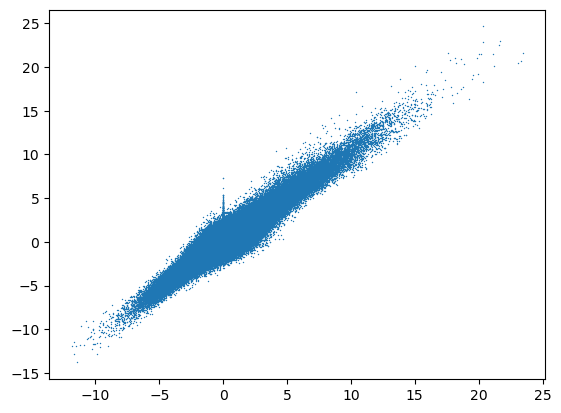

In [10]:
import seaborn as sns
sns.scatterplot(x=results_r.values.reshape((-1)), 
                y=results_py.X.reshape((-1)), linewidth=0, s=1)

pretty correlated~